In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from pandas import read_csv

In [8]:
def transform_train(train_df):
    
    # Remove missing values
    train_df = train_df.dropna(how = 'any', axis = 'rows')
    
    # Remove key column
    #train_df = train_df.drop(['key'], axis=1)
    
    # Remove absurd passenger_count
    #train_df = train_df[(train_df['passenger_count'] >= 1) &
    #                (train_df['passenger_count'] <= 6)]

    # Remove passenger_count column
    #train_df = train_df.drop(['passenger_count'], axis=1)

    # Remove negative and extreme fare_amount values
    train_df = train_df[(train_df['fare_amount'] >= 2.5) & (train_df['fare_amount'] <= 300)]
    print('Maximum fare_amount: %.1f' % train_df['fare_amount'].max())

    # Remove no displacements
    #train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude'])]
    #train_df = train_df[(train_df['pickup_longitude'] != train_df['dropoff_longitude'])]

    # Remove absurd displacements
    # A fixed value of 0.01 was added to the extreme coordinates in the test set
    # to permit finding neighbors within a radius < 0.01 around
    # pickup and dropoff locations
    train_df = train_df[(train_df['pickup_longitude'] >= lng1min+0.01) &
                        (train_df['pickup_longitude'] <= lng1max+0.01)]
    train_df = train_df[(train_df['dropoff_longitude'] >= lng2min+0.01) &
                        (train_df['dropoff_longitude'] <= lng2max+0.01)]
    train_df = train_df[(train_df['pickup_latitude'] >= lat1min+0.01) &
                        (train_df['pickup_latitude'] <= lat1max+0.01)]
    train_df = train_df[(train_df['dropoff_latitude'] >= lat2min+0.01) &
                        (train_df['dropoff_latitude'] <= lat2max+0.01)]

    # Create new features - dayofweek,hour,month,year
    train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek.astype('uint8')
    train_df['weekend'] = np.where(train_df.dayofweek < 5,0,1).astype('uint8')
    train_df['hour'] = train_df['pickup_datetime'].dt.hour.astype('uint8')
    train_df = train_df.drop(['dayofweek'], axis=1)
    #bins = IntervalIndex.from_tuples([(0, 6),
    #                                 (6, 12),
    #                                 (12, 16),
    #                                 (16,24)], closed='left')
    #train_df['h_class'] = cut(train_df['hour'], bins, labels=False)
    #train_df['h_class'] = np.where((train_df['hour'] >= 0) & (train_df['hour'] <= 6),1,0).astype('uint8')
    #train_df['h_class'] = np.where((train_df['hour'] >= 6) & (train_df['hour'] <= 12),2,train_df['h_class'])
    #train_df['h_class'] = np.where((train_df['hour'] >= 12) & (train_df['hour'] <= 16),3,train_df['h_class'])
    #train_df['h_class'] = np.where((train_df['hour'] >= 16) & (train_df['hour'] <= 20),4,train_df['h_class'])
    #train_df['h_class'] = np.where((train_df['hour'] >= 20) & (train_df['hour'] < 24),5,train_df['h_class'])
    #train_df['day'] = train_df['pickup_datetime'].dt.day.astype('uint8')
    #train_df['month'] = train_df['pickup_datetime'].dt.month.astype('uint8')
    #train_df['year'] = train_df['pickup_datetime'].dt.year.astype('uint16')

    # Create features for special rates
    train_df['eightpmto6am'] = np.where((train_df['hour'] >= 6) &
                                    (train_df['hour'] < 20),0,1).astype('uint8')
    #train_df['holiday'] = 
    train_df['rushhour'] = np.where((train_df['hour'] >= 16) &
                                    (train_df['hour'] < 20) &
                                    (train_df['weekend'] == 0),1,0).astype('uint8')
    train_df = train_df.drop(['hour','weekend'], axis=1)

    # Create dataframes for the two periods
    train_df['period'] = np.where(train_df['pickup_datetime'] < '2012-09-01',0,1).astype('uint8')
    
    # Save memory
    train_df = train_df.drop(['pickup_datetime'], axis=1)
    print(train_df.shape)
    return train_df

In [9]:
test_df = read_csv('test.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True)

In [10]:
lng1min = test_df.pickup_longitude.min()
lng2min = test_df.dropoff_longitude.min()
lat1min = test_df.pickup_latitude.min()
lat2min = test_df.dropoff_latitude.min()
#
lng1max = test_df.pickup_longitude.max()
lng2max = test_df.dropoff_longitude.max()
lat1max = test_df.pickup_latitude.max()
lat2max = test_df.dropoff_latitude.max()

# Model - Train100K (positions and period)

In [23]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32'}

cols = ['fare_amount', 'pickup_datetime',
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude']

train_df = read_csv('train100K.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True,
                   dtype = types, usecols=cols)

print(train_df.shape)

(100000, 6)


In [24]:
train_df = transform_train(train_df)
train_df.head()

Maximum fare_amount: 250.0
(97843, 6)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,period
0,10.5,-73.978989,40.761620,-73.963959,40.770561,1
1,7.5,-73.980347,40.763069,-73.988686,40.753979,1
2,4.5,-74.002281,40.726578,-74.009583,40.723598,0
3,14.5,-73.932800,40.758900,-73.995003,40.736599,0
4,13.0,-73.975418,40.761070,-73.998444,40.724892,1


In [25]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[:,1:].values
y = train_df.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.1, random_state=seed)
X_test.shape

(9785, 5)

In [26]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [54]:
%%time
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=15, n_jobs=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

CPU times: user 763 ms, sys: 395 ms, total: 1.16 s
Wall time: 316 ms


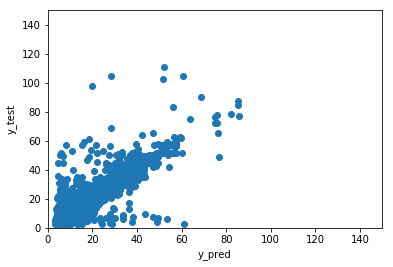

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.xlim(0,150)
plt.ylim(0,150)
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error
print('RMSE KNN: %.5f' % np.sqrt(mean_squared_error(y_pred,y_test)))

RMSE KNN: 3.96266


# Model - Train1M (positions and period)

In [11]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32'}

cols = ['fare_amount', 'pickup_datetime',
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude']

train_df = read_csv('train1M.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True,
                   dtype = types, usecols=cols)

print(train_df.shape)

(1000000, 6)


In [12]:
train_df = transform_train(train_df)
train_df.head()

Maximum fare_amount: 300.0
(978252, 8)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,eightpmto6am,rushhour,period
0,11.7,-73.998199,40.730412,-73.980789,40.767326,0,0,0
1,11.5,-73.960541,40.775360,-73.959793,40.775429,0,0,1
2,12.1,-73.984703,40.742599,-73.944702,40.780399,0,0,0
3,4.5,-73.986992,40.751293,-73.980659,40.758965,0,0,0
4,4.5,-73.953796,40.771084,-73.947227,40.775784,1,0,0


In [13]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[:,1:].values
y = train_df.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.01, random_state=seed)
X_test.shape

(9783, 7)

In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## KNN

In [15]:
%%time
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5, n_jobs=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

CPU times: user 30min 12s, sys: 16.5 s, total: 30min 28s
Wall time: 30min 23s


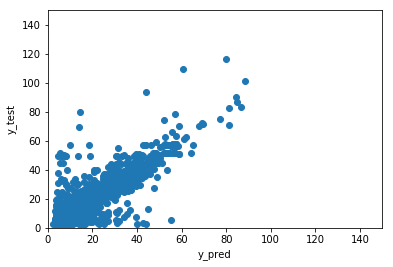

RMSE KNN: 3.66800


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.xlim(0,150)
plt.ylim(0,150)
plt.show()

from sklearn.metrics import mean_squared_error
print('RMSE KNN: %.5f' % np.sqrt(mean_squared_error(y_pred,y_test)))

# Model - Train2M (positions and period)

In [64]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32'}

cols = ['fare_amount', 'pickup_datetime',
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude']

train_df = read_csv('train1.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True,
                   dtype = types, usecols=cols)

print(train_df.shape)

(2000000, 6)


In [65]:
train_df = transform_train(train_df)
train_df.head()

Maximum fare_amount: 300.0
(1956532, 6)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,period
0,34.669998,-73.870819,40.773991,-73.999054,40.760658,0
1,4.000000,-74.004051,40.752945,-74.001144,40.746910,1
2,3.300000,-73.980865,40.750500,-73.981079,40.755962,0
3,7.300000,-73.979965,40.743340,-73.988792,40.759567,0
4,7.000000,-73.993851,40.720497,-74.007256,40.726669,1


In [66]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[:,1:].values
y = train_df.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.005, random_state=seed)
X_test.shape

(9783, 5)

In [67]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:
%%time
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=15, n_jobs=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

CPU times: user 1h 22min 15s, sys: 32.1 s, total: 1h 22min 47s
Wall time: 1h 22min 19s


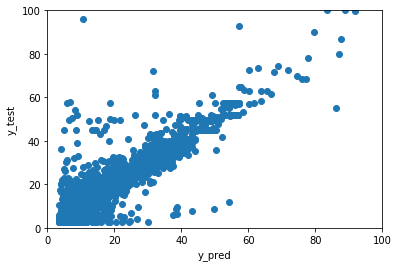

RMSE KNN: 3.90938


In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

from sklearn.metrics import mean_squared_error
print('RMSE KNN: %.5f' % np.sqrt(mean_squared_error(y_pred,y_test)))

# Remove outliers from the training set based on the residuals

# Model - Train1M (positions and period)

In [110]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32'}

cols = ['fare_amount', 'pickup_datetime',
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude']

train_df = read_csv('train1M.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True,
                   dtype = types, usecols=cols)

print(train_df.shape)

(1000000, 6)


In [111]:
train_df = transform_train(train_df)
train_df.head()

Maximum fare_amount: 300.0
(978252, 6)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,period
0,11.7,-73.998199,40.730412,-73.980789,40.767326,0
1,11.5,-73.960541,40.775360,-73.959793,40.775429,1
2,12.1,-73.984703,40.742599,-73.944702,40.780399,0
3,4.5,-73.986992,40.751293,-73.980659,40.758965,0
4,4.5,-73.953796,40.771084,-73.947227,40.775784,0


In [112]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.01, random_state=seed)
X_test.shape

(9783, 5)

In [113]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [114]:
%%time
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=10, n_jobs=4)
neigh.fit(X_train, y_train)

CPU times: user 5.12 s, sys: 31.5 ms, total: 5.15 s
Wall time: 5.14 s


In [115]:
y_pred = neigh.predict(X_train)
y_pred_test = neigh.predict(X_test)

R^2: 0.8727
MSE: 11.7196
MAE: 1.5939
rms: 3.4234


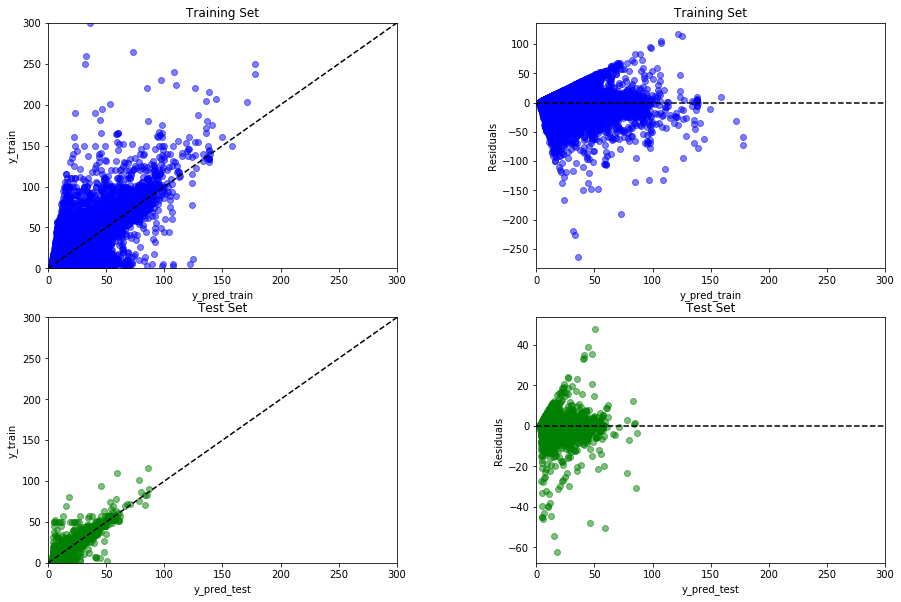

RMSE KNN: 3.50667


In [123]:
K = X_train.shape[1]+1
rms = np.sqrt(sum((y_train-y_pred)**2)/(len(y_train)-K))

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('R^2: %.4f' % r2_score(y_train,y_pred))
print('MSE: %.4f' % mean_squared_error(y_train,y_pred))
print('MAE: %.4f' % mean_absolute_error(y_train,y_pred))
print('rms: %.4f' % rms)

plt.figure(figsize=(15, 20))
ax1 = plt.subplot(221)
ax1.scatter(y_pred, y_train, c = 'blue', alpha = 0.5)
ax1.plot((0,300),(0,300), c = 'black', linestyle = 'dashed')
ax1.set_title('Training Set')
ax1.set_xlabel('y_pred_train')
ax1.set_ylabel('y_train')
ax1.set_xlim(0,300)
ax1.set_ylim(0,300)

ax2 = plt.subplot(222)
ax2.scatter(y_pred, y_pred - y_train, c = 'blue', alpha = 0.5)
ax2.plot((0,300),(0,0), c = 'black', linestyle = 'dashed')
ax2.set_title('Training Set')
ax2.set_xlabel('y_pred_train')
ax2.set_ylabel('Residuals')
ax2.set_xlim(0,300)

ax3 = plt.subplot(223)
ax3.scatter(y_pred_test, y_test, c = 'green', alpha = 0.5)
ax3.plot((0,300),(0,300), c = 'black', linestyle = 'dashed')
ax3.set_title('Test Set')
ax3.set_xlabel('y_pred_test')
ax3.set_ylabel('y_train')
ax3.set_xlim(0,300)
ax3.set_ylim(0,300)

ax4 = plt.subplot(224)
ax4.scatter(y_pred_test, y_pred_test - y_test, c = 'green', alpha = 0.5)
ax4.plot((0,300),(0,0), c = 'black', linestyle = 'dashed')
ax4.set_title('Test Set')
ax4.set_xlabel('y_pred_test')
ax4.set_ylabel('Residuals')
ax4.set_xlim(0,300)

plt.subplots_adjust(wspace=0.4, top=0.5)
plt.show()

print('RMSE KNN: %.5f' % np.sqrt(mean_squared_error(y_pred_test,y_test)))

In [124]:
# Find outliers
res = y_pred - y_train
out = res[(res<-50) & (res<-50)].index
out.shape

(253,)

In [125]:
out

Int64Index([650385, 907744,  76335, 552050, 115412, 997935, 348043, 426393,
            672909, 376165,
            ...
            985174, 273204, 212255, 541146, 457760, 433443, 953674, 269021,
            456864, 363565],
           dtype='int64', length=253)

# Learn the model with no outliers

In [126]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32'}

cols = ['fare_amount', 'pickup_datetime',
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude']

train_df = read_csv('train1M.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True,
                   dtype = types, usecols=cols)
train_df = train_df.drop(out)
print(train_df.shape)

(999747, 6)


In [127]:
train_df = transform_train(train_df)
train_df.head()

Maximum fare_amount: 277.8
(977999, 6)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,period
0,11.7,-73.998199,40.730412,-73.980789,40.767326,0
1,11.5,-73.960541,40.775360,-73.959793,40.775429,1
2,12.1,-73.984703,40.742599,-73.944702,40.780399,0
3,4.5,-73.986992,40.751293,-73.980659,40.758965,0
4,4.5,-73.953796,40.771084,-73.947227,40.775784,0


In [128]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.01, random_state=seed)
X_test.shape

(9780, 5)

In [129]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [130]:
%%time
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=10, n_jobs=4)
neigh.fit(X_train, y_train)

CPU times: user 5.25 s, sys: 47.5 ms, total: 5.29 s
Wall time: 5.26 s


In [131]:
y_pred = neigh.predict(X_train)
y_pred_test = neigh.predict(X_test)

R^2: 0.8889
MSE: 9.8735
MAE: 1.5660
rms: 3.1422


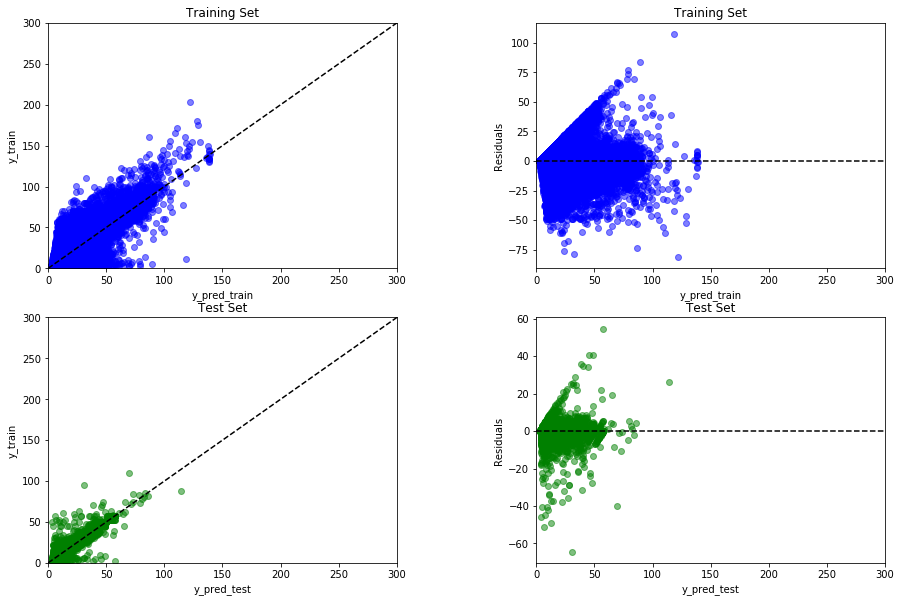

RMSE KNN: 3.55115


In [132]:
K = X_train.shape[1]+1
rms = np.sqrt(sum((y_train-y_pred)**2)/(len(y_train)-K))

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('R^2: %.4f' % r2_score(y_train,y_pred))
print('MSE: %.4f' % mean_squared_error(y_train,y_pred))
print('MAE: %.4f' % mean_absolute_error(y_train,y_pred))
print('rms: %.4f' % rms)

plt.figure(figsize=(15, 20))
ax1 = plt.subplot(221)
ax1.scatter(y_pred, y_train, c = 'blue', alpha = 0.5)
ax1.plot((0,300),(0,300), c = 'black', linestyle = 'dashed')
ax1.set_title('Training Set')
ax1.set_xlabel('y_pred_train')
ax1.set_ylabel('y_train')
ax1.set_xlim(0,300)
ax1.set_ylim(0,300)

ax2 = plt.subplot(222)
ax2.scatter(y_pred, y_pred - y_train, c = 'blue', alpha = 0.5)
ax2.plot((0,300),(0,0), c = 'black', linestyle = 'dashed')
ax2.set_title('Training Set')
ax2.set_xlabel('y_pred_train')
ax2.set_ylabel('Residuals')
ax2.set_xlim(0,300)

ax3 = plt.subplot(223)
ax3.scatter(y_pred_test, y_test, c = 'green', alpha = 0.5)
ax3.plot((0,300),(0,300), c = 'black', linestyle = 'dashed')
ax3.set_title('Test Set')
ax3.set_xlabel('y_pred_test')
ax3.set_ylabel('y_train')
ax3.set_xlim(0,300)
ax3.set_ylim(0,300)

ax4 = plt.subplot(224)
ax4.scatter(y_pred_test, y_pred_test - y_test, c = 'green', alpha = 0.5)
ax4.plot((0,300),(0,0), c = 'black', linestyle = 'dashed')
ax4.set_title('Test Set')
ax4.set_xlabel('y_pred_test')
ax4.set_ylabel('Residuals')
ax4.set_xlim(0,300)

plt.subplots_adjust(wspace=0.4, top=0.5)
plt.show()

print('RMSE KNN: %.5f' % np.sqrt(mean_squared_error(y_pred_test,y_test)))